In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# 设置字体为 SimHei（黑体），或者其他支持中文的字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置字体
plt.rcParams['axes.unicode_minus'] = False  # 正常显示负号

In [ ]:
# 获取当前文件所在目录的父目录
import os
import sys

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)

if parent_dir not in sys.path:
    sys.path.append(parent_dir)


from Dtool import fill_missing_values, plot_factors_by_pattern, plot_comparison_multiple, reverse_column, plot_feature_importance,plot_predictions


In [3]:
sheet = pd.read_excel('data_input_auto/柴油独立炼厂产量.xlsx', sheet_name='Sheet1').rename(columns={'DataTime': 'Date'})
sheet = sheet.set_index('Date')
last_day = sheet['柴油：独立炼厂：产量：中国（周）'].last_valid_index()

future_data_30days = sheet[sheet.index > last_day]
target_days = pd.date_range(start=last_day+ pd.DateOffset(1), periods=30, freq='B')
target_end = target_days[-1]
new_index = pd.date_range(start=last_day+ pd.DateOffset(1), end=target_end, freq='B')
sheet = sheet.reindex(sheet.index.union(new_index))
sheet = sheet[sheet.index <= target_end]

sheet.tail()

,柴油：独立炼厂：产量：中国（周）,山东柴油裂解差/5DMA,Kpler-山东原油进口量（周度）/4WMA
2025-06-09,NaN,NaN,NaN
2025-06-10,NaN,NaN,NaN
2025-06-11,NaN,NaN,NaN
2025-06-12,NaN,NaN,NaN
2025-06-13,NaN,NaN,NaN


In [4]:
sheet.columns

Index(['柴油：独立炼厂：产量：中国（周）', '山东柴油裂解差/5DMA', 'Kpler-山东原油进口量（周度）/4WMA'], dtype='object')

In [5]:
################################# 处理缺失值 #################################
fill_methods = {
'山东柴油裂解差/5DMA':'interpolate', 
'Kpler-山东原油进口量（周度）/4WMA':'interpolate'
} 
sheet= fill_missing_values(sheet, fill_methods, return_only_filled=False)
sheet.loc[:last_day, '柴油：独立炼厂：产量：中国（周）'] = sheet.loc[:last_day, '柴油：独立炼厂：产量：中国（周）'].interpolate(method='linear')

#################################  因子处理  #################################

sheet['山东柴油裂解差/5DMA_提前25天'] = sheet['山东柴油裂解差/5DMA'].shift(25)
sheet['Kpler-山东原油进口量（周度）/4WMA_提前20天'] = sheet['Kpler-山东原油进口量（周度）/4WMA'].shift(20)

################################# 数据筛选  #################################

sheet_daily = sheet.reset_index().rename(columns={'index': 'Date'})
sheet_daily['Date'] = pd.to_datetime(sheet_daily['Date'])

sheet_daily = sheet_daily[sheet_daily['Date'] >= pd.Timestamp('2023-05-01')]

sheet_daily = sheet_daily.reset_index(drop=True)
sheet_daily = sheet_daily[
    (sheet_daily['Date'] > last_day) | 
    (sheet_daily['柴油：独立炼厂：产量：中国（周）'].notna())
]

################################# 数据 读取-处理 结束 #################################

In [6]:
# 转换为周度数据,每周五
sheet_daily['周'] = sheet_daily['Date'].dt.to_period('W-FRI')

# 按周聚合数据
agg_func = lambda x: x.mean() if not x.isna().all() else np.nan
sheet_weekly = sheet_daily.groupby('周').agg({
    '柴油：独立炼厂：产量：中国（周）': agg_func,
    '山东柴油裂解差/5DMA_提前25天': agg_func,
    'Kpler-山东原油进口量（周度）/4WMA_提前20天': agg_func
}).reset_index()

# 转换日期格式并返回结果,每周五
sheet_weekly['Date'] = sheet_weekly['周'].dt.to_timestamp(freq='W-FRI')
sheet_daily = sheet_weekly.drop('周', axis=1)
sheet_daily

,柴油：独立炼厂：产量：中国（周）,山东柴油裂解差/5DMA_提前25天,Kpler-山东原油进口量（周度）/4WMA_提前20天,Date
0,185.494633,1000.820767,3800.437500,2023-05-05
1,184.528800,792.689183,3570.385417,2023-05-12
2,183.203140,644.776480,3479.250000,2023-05-19
3,179.105700,769.117640,3523.945000,2023-05-26
4,173.145080,867.478360,3694.730000,2023-06-02
...,...,...,...,...
106,NaN,874.906680,3557.875000,2025-05-16
107,NaN,852.113100,3811.583333,2025-05-23
108,NaN,689.150450,4248.266667,2025-05-30
109,NaN,637.187320,4271.250000,2025-06-06


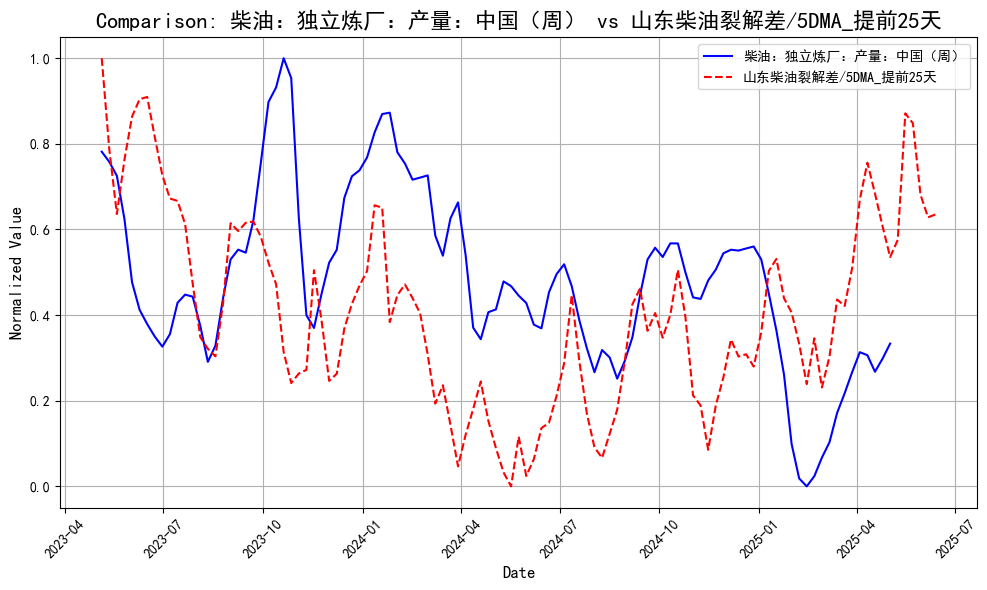

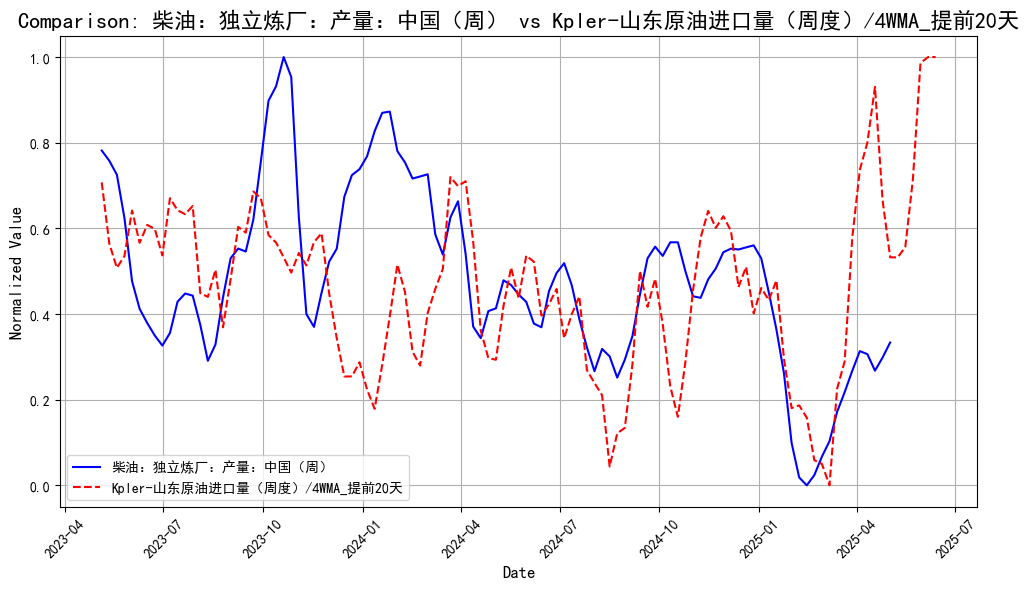

In [7]:
sheet_daily_plot = sheet_daily.set_index('Date')
plot_comparison_multiple(
    sheet_daily_plot, 
    main_col='柴油：独立炼厂：产量：中国（周）', 
    compare_cols=[
        '山东柴油裂解差/5DMA_提前25天',
        'Kpler-山东原油进口量（周度）/4WMA_提前20天'
        ]
)

In [8]:
################################# 划分 数据 训练 测试 预测 #################################
# 划分训练集、测试集和未来数据、设置测试集长度
train_data = sheet_daily[sheet_daily['Date'] <= last_day].copy()
test_period = 4
test_data = train_data[-test_period:].copy() 
train_data = train_data[:-test_period].copy()
future_data = sheet_daily[sheet_daily['Date'] > last_day].copy()

feature_columns = [
        '山东柴油裂解差/5DMA_提前25天',
        'Kpler-山东原油进口量（周度）/4WMA_提前20天'
]

predict_column = '柴油：独立炼厂：产量：中国（周）'

X_train = train_data[feature_columns]
y_train = train_data[predict_column]

X_test = test_data[feature_columns]
y_test = test_data[predict_column]

X_future = future_data[feature_columns]

################################# Xgboost 模型 训练 测试 预测 #################################

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_future_scaled = scaler.transform(X_future)

train_dmatrix_huber = xgb.DMatrix(X_train_scaled, label=y_train)
train_dmatrix_zscore = xgb.DMatrix(X_train_scaled, label=y_train)
test_dmatrix = xgb.DMatrix(X_test_scaled, label=y_test)
future_dmatrix = xgb.DMatrix(X_future_scaled)

# 计算样本权重 - 使用Huber损失函数的思想降低异常值影响
residuals = np.abs(y_train - y_train.mean())
delta = np.percentile(residuals, 70)  # 使用90%分位数作为阈值
sample_weights_huber = np.where(residuals <= delta, 1.0, delta/residuals)
train_dmatrix_huber.set_weight(sample_weights_huber)

# 使用z-score思路计算样本权重
z_scores = np.abs((y_train - y_train.mean()) / y_train.std())
z_threshold = 2.0  # 设置z-score阈值为2个标准差
sample_weights_zscore = np.where(z_scores <= z_threshold, 1.0, z_threshold/z_scores)
train_dmatrix_zscore.set_weight(sample_weights_zscore)

# 设置XGBoost参数
params = {
    'objective': 'reg:squarederror',  # 回归任务
    'learning_rate': 0.16840192317066896, 
    'max_depth': 8, 
    'min_child_weight': 3.7140857764851223, 
    'subsample': 0.7535144901121249, 
    'colsample_bytree': 0.9682697906982136, 
    'gamma': 9.33096400364767e-05, 
    'reg_alpha': 0.0003446087666219011, 
    'reg_lambda': 0.2734911516789055, 
    'eval_metric': 'rmse', # 评估指标：选择“rmse”
    'seed': 42, # 随机种子
#    'max_delta_step': 5,
#    'tree_method': 'auto'
}





num_boost_round = 5000
evals_result = {}

# 模型训练
model = xgb.train(
    params,
    train_dmatrix_huber,  # 使用带权重的DMatrix
    num_boost_round, # 训练最大轮数
    evals=[(test_dmatrix, 'eval'), (train_dmatrix_huber, 'train')],  # 更新评估数据集
    early_stopping_rounds=100,  # 早停策略：若连续50轮验证集的误差没有改善，则停止训练
    evals_result=evals_result,  # 保存训练过程中的评估结果
    verbose_eval=500 # 每100轮输出一次评估信息
)


y_train_pred_dmatrix = model.predict(train_dmatrix_huber)
y_test_pred_dmatrix = model.predict(test_dmatrix)

train_mse = mean_squared_error(y_train, y_train_pred_dmatrix)
test_mse = mean_squared_error(y_test, y_test_pred_dmatrix)
train_r2 = r2_score(y_train, y_train_pred_dmatrix)
test_r2 = r2_score(y_test, y_test_pred_dmatrix)
print(f"训练集 MSE (DMatrix): {round(train_mse, 4)}, 训练集 R² (DMatrix): {round(train_r2, 4)}")
print(f"测试集 MSE (DMatrix): {round(test_mse, 4)}, 测试集 R² (DMatrix): {round(test_r2, 4)}")

##### 预测未来 非全部数据 和 结果存储（y_test,y_future） #####
y_future_pred_dmatrix = model.predict(future_dmatrix)
test_data.loc[:, '预测值'] = y_test_pred_dmatrix
future_data.loc[:, '预测值'] = y_future_pred_dmatrix

[0]	eval-rmse:7.51760	train-rmse:6.94317


[500]	eval-rmse:11.45678	train-rmse:0.30297


[1000]	eval-rmse:11.95125	train-rmse:0.05758

[1500]	eval-rmse:12.02270	train-rmse:0.01702


[2000]	eval-rmse:12.03166	train-rmse:0.01082


[2500]	eval-rmse:12.03271	train-rmse:0.00941

[3000]	eval-rmse:12.03333	train-rmse:0.00868


[3500]	eval-rmse:12.03432	train-rmse:0.00818

[2000]	eval-rmse:7.81615	train-rmse:0.01121


[4000]	eval-rmse:12.03474	train-rmse:0.00799

[4500]	eval-rmse:12.03472	train-rmse:0.00762

[4999]	eval-rmse:12.03580	train-rmse:0.00734

训练集 MSE (DMatrix): 0.0001, 训练集 R² (DMatrix): 1.0
测试集 MSE (DMatrix): 144.8604, 测试集 R² (DMatrix): -159.4859


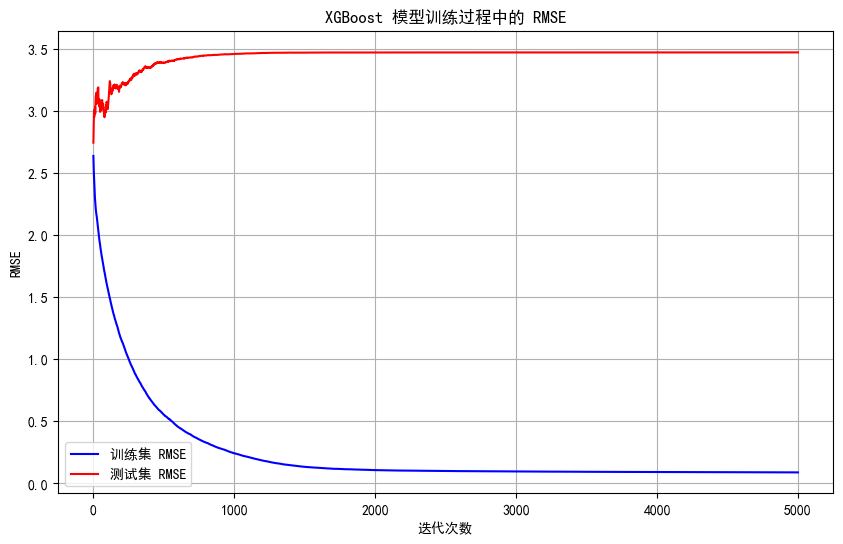

In [9]:
# 可视化训练过程中的评估指标
plt.figure(figsize=(10, 6))
train_rmse = np.sqrt(evals_result['train']['rmse'])
test_rmse = np.sqrt(evals_result['eval']['rmse'])

epochs = len(train_rmse)
x_axis = range(epochs)

plt.plot(x_axis, train_rmse, label='训练集 RMSE', color='blue')
plt.plot(x_axis, test_rmse, label='测试集 RMSE', color='red')

plt.xlabel('迭代次数')
plt.ylabel('RMSE')
plt.title('XGBoost 模型训练过程中的 RMSE')
plt.legend()
plt.grid(True)
plt.show()

In [10]:
################################# Xgboost 模型 训练 测试 预测 所有数据 #################################
X_all = pd.concat([X_train, X_test]).reset_index(drop=True)
y_all = pd.concat([y_train, y_test]).reset_index(drop=True)

X_all_scaled = scaler.transform(X_all)
X_future_scaled = scaler.transform(X_future)

# 创建 DMatrix 对象
all_data_dmatrix = xgb.DMatrix(X_all_scaled, label=y_all)
future_dmatrix_all = xgb.DMatrix(X_future_scaled)

# 计算所有数据的样本权重
residuals_all = np.abs(y_all - y_all.mean())
sample_weights_all = np.where(residuals_all <= delta, 1.0, delta / residuals_all)

all_data_dmatrix.set_weight(sample_weights_all)  # 加入样本权重

# 训练模型
model_all = xgb.train(
    params,
    all_data_dmatrix,
    num_boost_round,
    evals=[(all_data_dmatrix, 'train')],
    early_stopping_rounds=100,
    evals_result=evals_result,
    verbose_eval=500
)

y_all_pred = model_all.predict(all_data_dmatrix)
y_future_pred_all = model_all.predict(future_dmatrix_all)

all_mse = mean_squared_error(y_all, y_all_pred)
all_r2 = r2_score(y_all, y_all_pred)

print(f"全部数据 MSE: {round(all_mse, 4)}, 全部数据 R²: {round(all_r2, 4)}")

# 存储全部数据的预测结果
all_data = pd.concat([train_data, test_data]).reset_index(drop=True)
all_data.loc[:, '预测值_全量'] = y_all_pred
future_data.loc[:, '预测值_全量'] = y_future_pred_all

[0]	train-rmse:6.92825


[500]	train-rmse:0.19079


[1000]	train-rmse:0.01364


[1500]	train-rmse:0.00886


[2000]	train-rmse:0.00771


[2500]	train-rmse:0.00741

[1500]	train-rmse:0.00893


[3000]	train-rmse:0.00712


[3500]	train-rmse:0.00694

[4000]	train-rmse:0.00682


[4500]	train-rmse:0.00667

[4999]	train-rmse:0.00656

全部数据 MSE: 0.0001, 全部数据 R²: 1.0

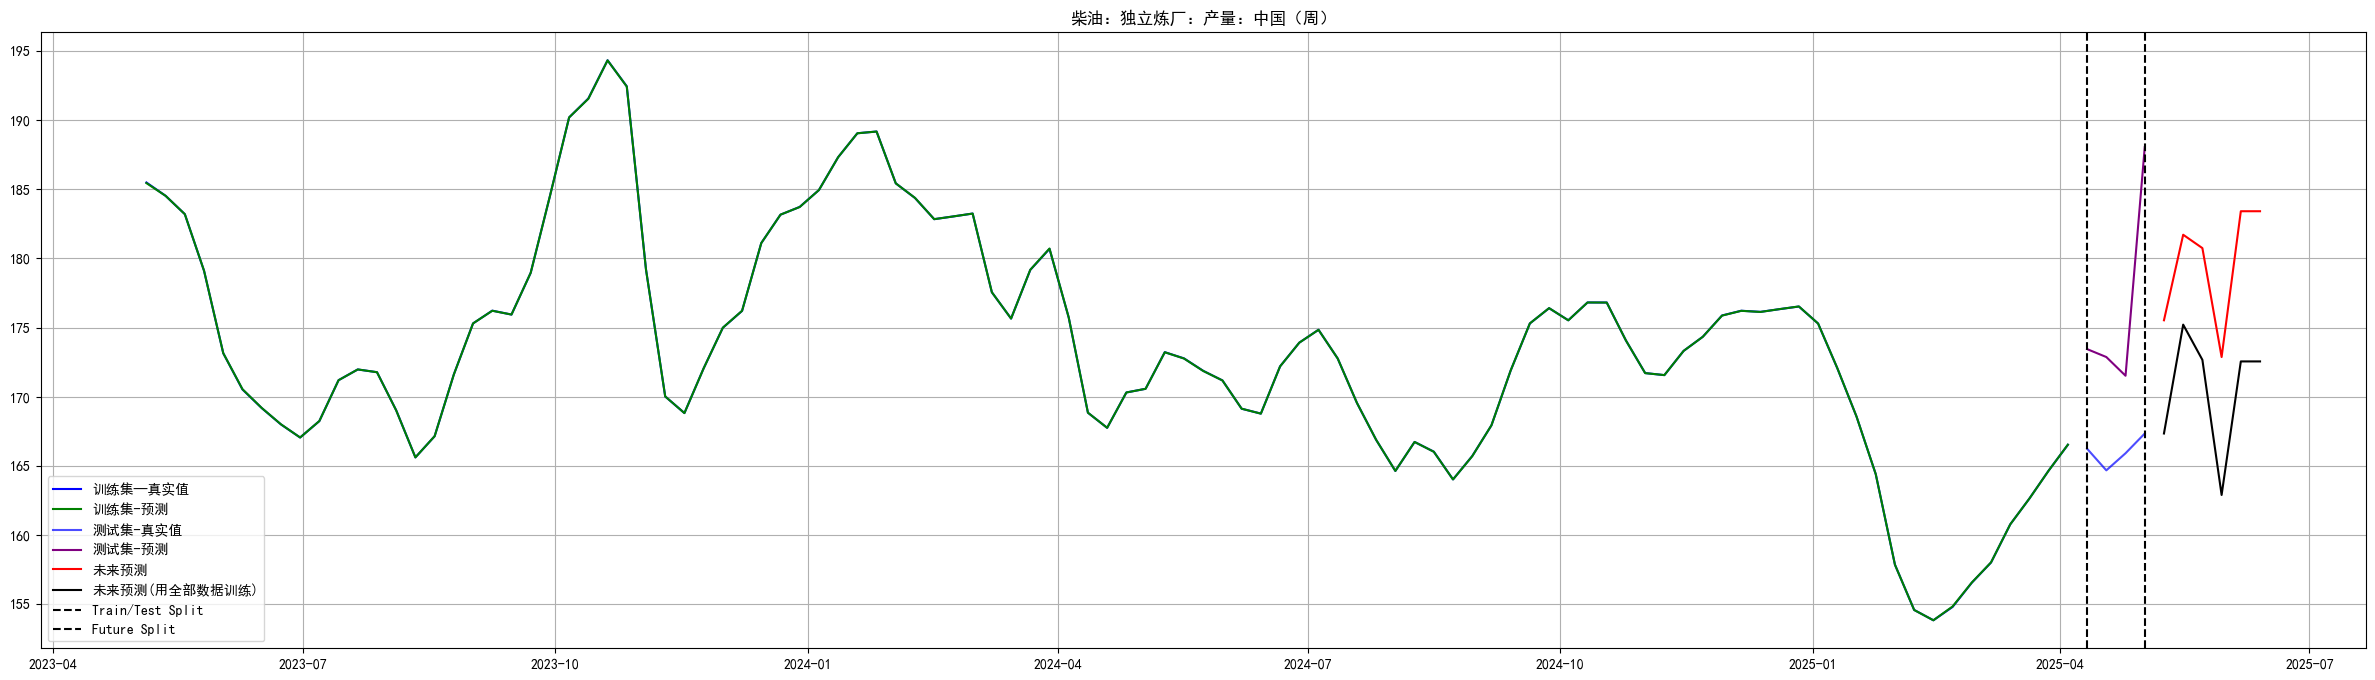

In [11]:
plt.figure(figsize=(30, 8))
# 绘制主要数据
future_data = plot_predictions(y_test, future_data, col=True, label=True)
future_data = plot_predictions(y_test, future_data, col=True, label=True)
plt.plot(train_data['Date'], y_train, label='训练集—真实值', color='blue')
plt.plot(train_data['Date'], y_train_pred_dmatrix, label='训练集-预测', color='green')
plt.plot(test_data['Date'], y_test, label='测试集-真实值', color='blue', alpha=0.7)
plt.plot(test_data['Date'], y_test_pred_dmatrix, label='测试集-预测', color='purple')
plt.plot(future_data['Date'], future_data['预测值'], label='未来预测', color='red')
plt.plot(future_data['Date'], future_data['预测值_全量'], label='未来预测(用全部数据训练)', color='black')

# 添加分割线
plt.axvline(x=test_data['Date'].iloc[0], color='black', linestyle='--', label='Train/Test Split')
plt.axvline(x=last_day, color='black', linestyle='--', label='Future Split')

# 设置标题和图例
plt.title('柴油：独立炼厂：产量：中国（周）')
plt.legend()
plt.grid(True)
plt.show()

---

In [12]:
################################# 训练预测数据 excel格式输出  #################################
'''
1. 日度数据 （真实值 和 预测值）
2. 月度数据 （真实值、训练值、预测值）
'''

############ 日度 数据 ############
# 创建日度数据框
historical_actual_daily = pd.DataFrame({
    'Date': pd.concat([train_data['Date'], test_data['Date']]),
    '真实值': pd.concat([y_train, y_test])
})
# 只保留2023年之后的数据
historical_actual_daily = historical_actual_daily[historical_actual_daily['Date'].dt.year >= 2023]
# 创建预测数据框
future_pred_daily = pd.DataFrame({
    'Date': future_data['Date'],
    '预测值': future_data['预测值_全量']
})


merged_df_daily = pd.merge(historical_actual_daily, future_pred_daily, on='Date', how='outer')
merged_df_daily = merged_df_daily.sort_values('Date', ascending=False)
merged_df_daily['Date'] = merged_df_daily['Date'].dt.strftime('%Y/%m/%d')
merged_df_daily.to_excel('eta/柴油独立炼厂产量_合并数据.xlsx', index=False,float_format='%.1f')

merged_df_daily

,Date,真实值,预测值
110,2025/06/13,NaN,172.553192
109,2025/06/06,NaN,172.553192
108,2025/05/30,NaN,162.894653
107,2025/05/23,NaN,172.665558
106,2025/05/16,NaN,175.214188
...,...,...,...
4,2023/06/02,173.145080,NaN
3,2023/05/26,179.105700,NaN
2,2023/05/19,183.203140,NaN
1,2023/05/12,184.528800,NaN


In [13]:
############ 月度 数据 ############
# 历史真实值
historical_actual_monthly = pd.DataFrame({
    'Date': pd.concat([train_data['Date'], test_data['Date']]),
    '真实值': pd.concat([y_train, y_test])
})
# 真实数据 只保留2023年之后的
historical_actual_monthly = historical_actual_monthly[historical_actual_monthly['Date'].dt.year >= 2023]
# 2024年及以后训练集预测值
train_pred_2024 = pd.DataFrame({
    'Date': train_data[train_data['Date'].dt.year >= 2024]['Date'],
    '预测值': y_train_pred_dmatrix[train_data['Date'].dt.year >= 2024]
})
# 2024年及以后c测试集集预测值
test_pred_2024 = test_data[['Date', '预测值']].copy()
# 未来预测值 
future_pred_2024 = pd.DataFrame({
    'Date': future_data['Date'],
    '预测值': future_data['预测值_全量']
})
# 合并 训练集预测+测试集预测+未来预测
future_pred_monthly = pd.concat([
    train_pred_2024, 
    test_pred_2024, 
    future_pred_2024
    ], axis=0).sort_values('Date')

# 合并历史真实值和预测值
merged_df_monthly = pd.merge(historical_actual_monthly, future_pred_monthly, on='Date', how='outer')
merged_df_monthly.set_index('Date', inplace=True)
merged_df_monthly = merged_df_monthly.resample('ME').mean()
merged_df_monthly.reset_index(inplace=True)
merged_df_monthly =merged_df_monthly.sort_values('Date', ascending=False)
merged_df_monthly['Date'] = merged_df_monthly['Date'].dt.strftime('%Y/%m/%d')
# 保存成excel
merged_df_monthly.to_excel('eta/柴油独立炼厂产量_月度数据.xlsx', index=False, float_format='%.1f')
merged_df_monthly

,Date,真实值,预测值
25,2025/06/30,NaN,172.553192
24,2025/05/31,167.340000,173.232956
23,2025/04/30,165.837083,171.091125
22,2025/03/31,161.519542,161.520935
21,2025/02/28,154.939015,154.949463
20,2025/01/31,167.633650,167.635544
19,2024/12/31,176.303563,176.302795
18,2024/11/30,173.359833,173.357254
17,2024/10/31,175.806244,175.804504
16,2024/09/30,172.880938,172.885620


In [14]:
from Dcel import update_excel_data
# 使用示例
file_path = "eta/1.汽柴煤油_数据上传.xlsx"
sheet_name = "日度数据表"
identifier = "柴油独立炼厂产量"

# 调用函数更新数据
success = update_excel_data(merged_df_daily, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")

成功更新 日度数据表 中的数据
数据已成功更新到Excel文件


In [15]:
from Lcel import update_excel_data
file_path = "eta/1.汽柴煤油_数据上传.xlsx"
sheet_name = "详情页"
identifier = "柴油独立炼厂产量"       # NEW: 新增日期标识符列的抬头
# 调用函数更新数据
success = update_excel_data(merged_df_monthly, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")


已完成：插入/更新数据，并重新计算“方向/偏差率” (protected_date = 2025/04/30)
数据已成功更新到Excel文件
